In [65]:
from __future__ import annotations
import typing
from dataclasses import dataclass
import warnings
from contextlib import contextmanager
import itertools

In [66]:
import numpy as np
import matplotlib.pyplot as plt

In [67]:
@contextmanager
def localize_globals(*exceptions: str, restore_values: bool = True):
    exceptions: typing.Set[str] = set(exceptions)

    old_globals: typing.Dict[str, typing.Any] = dict(globals())
    allowed: typing.Set[str] = set(old_globals.keys())
    allowed.update(exceptions)

    yield None

    new_globals: typing.Dict[str, typing.Any] = globals()

    for name in tuple(new_globals.keys()):
        if name not in allowed:
            del new_globals[name]
    
    if not restore_values:
        return
    
    new_globals.update(
        {k: v for k, v in old_globals.items() if k not in exceptions}
    )

In [68]:
@dataclass(frozen=True)
class Equation:
    A: np.ndarray
    b: np.ndarray
    
    @staticmethod
    def random(size: int) -> Equation:
        # TODO: Better matrix?
        
        A: np.ndarray = np.eye(size) + 0.1 * np.random.rand(size, size)
        A = A @ A.T
        b: np.ndarray = np.random.rand(size)
        
        return Equation(A, b)

In [69]:
def solve_seidel(equation: Equation,
                 max_iter: int = 10000,
                 tol: float = 1e-8) -> tuple[np.ndarray, list[float]]:
    residuals: list[float] = []
    
    A: np.ndarray = equation.A
    b: np.ndarray = equation.b
    
    x: np.ndarray = np.zeros_like(b)
    
    for _ in range(max_iter):
        for i in range(len(x)):
            x[i] = b[i]
            
            for j in range(len(x)):
                if j == i:
                    continue
                
                x[i] -= A[i, j] * x[j]
            
            x[i] /= A[i, i]
        
        residual: float = np.linalg.norm(A @ x - b)
        if residual < tol:
            break
        
        residuals.append(residual)
    
    return x, residuals


In [70]:
np.random.seed(42)
equation: Equation = Equation.random(100)

In [71]:
true_solution: np.ndarray = np.linalg.solve(equation.A, equation.b)

In [72]:
solution: np.ndarray
residuals: list[float]
solution, residuals = solve_seidel(equation)

In [73]:
print(f"Done in {len(residuals)} iterations with error of {np.linalg.norm(solution - true_solution)}")

Done in 752 iterations with error of 9.322311588928374e-09


In [74]:
assert np.allclose(solution, true_solution)

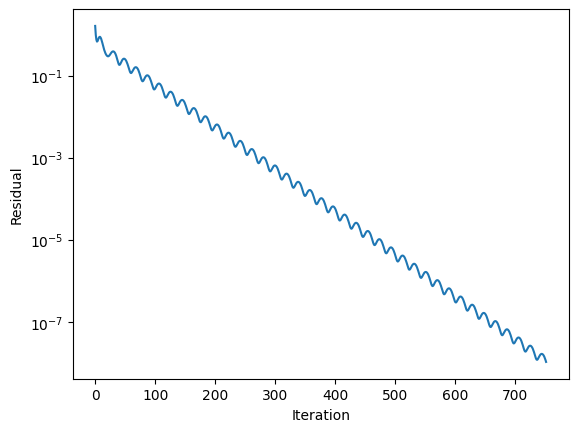

In [75]:
with localize_globals():
    fig, ax = plt.subplots()
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Residual')
    
    ax.set_yscale('log')
    
    ax.plot(residuals)
